In [5]:
!pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 31.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 44.1 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
  Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. pip 23.1 will enforce this behaviour change. A possible replacement is to fix the wheel build issue repo

In [1]:
import tensorflow as tf
from tensorflow.python.keras import layers
import tensorflow_probability as tfp
from tensorflow.keras.optimizers import Adam
import tqdm
import numpy as np
import gym
import matplotlib.pyplot as plt

env = gym.make("LunarLander-v2")

In [2]:
class Net(tf.keras.Model):

    def _init_(self, actions_count):
        super()._init_()

        self.hl = layers.Dense(128, activation='LeakyReLU')
        self.act = layers.Dense(actions_count)
        self.critic = layers.Dense(5)

    def call(self, array_input):
        value_estimate = self.hl(array_input, training = False)
        return tfp.distributions.Categorical(logits = self.act(value_estimate)), self.critic(value_estimate)

In [3]:
class Model_Agent:

    def _init_(self, env):

        self.gamma = 0.99
        self.env = env
        self.model = Net(self.env.action_space.n)
        self.loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)
        self.optimizer = Adam(learning_rate=0.001)

    @tf.function
    def exec(self, first):

        first_shape = first.shape
        state = first
        state = tf.expand_dims(state, 0)
        episode_reward = tf.constant(0.0)
        reward_shape = episode_reward.shape

        for i in tf.range(1000):
            with tf.GradientTape() as grad:
                action_logits, value = self.model(state)
                action = action_logits.sample()[0]

                possibs = action_logits.log_prob(action)

                state, reward, done = self.environment_step(action)
                state.set_shape(first_shape)
                state = tf.expand_dims(state, 0)
                episode_reward = tf.add(episode_reward, reward)
                episode_reward.set_shape(reward_shape)

                _, further = self.model(state)

                further = tf.where(done == 0, further, 0)

                loss = self.loss_calc(value, possibs, reward, further)

            grads = grad.gradient(loss, self.model.trainable_variables)

            self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

            if tf.cast(done, tf.bool):
                break

        return episode_reward

    def loss_calc(self, value, possibs, reward, further):

        goal_value = reward + 0.99 * further
        loss_critic = self.loss(goal_value, value)
        advantage = goal_value - value
        loss_act = - possibs * advantage

        return loss_critic + loss_act

    def environment_step(self, input_arr: tf.Tensor):
        return tf.numpy_function(self.get_environment, [input_arr], [tf.float32, tf.float32, tf.int32])

    def learn(self, reward_threshold=200):

        episodes_reward = []

        with tqdm.trange(7000) as t:
            for i in t:
                initial_state = tf.constant(self.env.reset(), dtype=tf.float32)
                episode_reward = int(self.exec(initial_state))

                episodes_reward.append(episode_reward)
                present = np.mean(episodes_reward[-100:])

                t.set_description(f'Episode {i}')
                t.set_postfix(episode_reward=episode_reward, running_reward=present)

        plt.plot(episodes_reward)
        plt.xlabel('Episode')
        plt.ylabel('Score')
        plt.show()

    def get_environment(self, action: np.ndarray):

        state, reward, done, _ = self.env.step(action)
        return state.astype(np.float32), np.array(reward, np.float32), np.array(done, np.int32)

Episode 6999: 100%|██████████| 7000/7000 [40:51<00:00,  2.86it/s, episode_reward=-163, running_reward=-196]


Solved at episode 6999: average reward: -195.76!


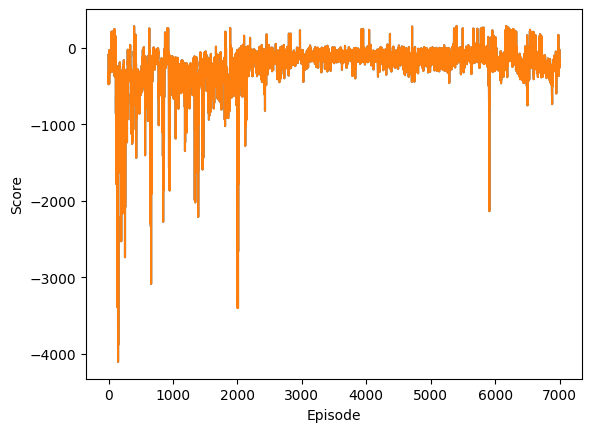

In [4]:
agent = Model_Agent(env)
agent.learn()